# Working with LLMs SDKs

In [ ]:
! pip install openai

## Azure OpenAI

To successfully make a call against Azure OpenAI, you need an endpoint and a key.

Go to your resource in the Azure portal. The Keys & Endpoint section can be found in the Resource Management section. Copy your endpoint and access key as you'll need both for authenticating your API calls. You can use either KEY1 or KEY2. Always having two keys allows you to securely rotate and regenerate keys without causing a service disruption.

You can find the full tutorial here: https://learn.microsoft.com/en-us/azure/ai-services/openai/gpt-v-quickstart?tabs=command-line%2Ckeyless%2Ctypescript-keyless&pivots=programming-language-python

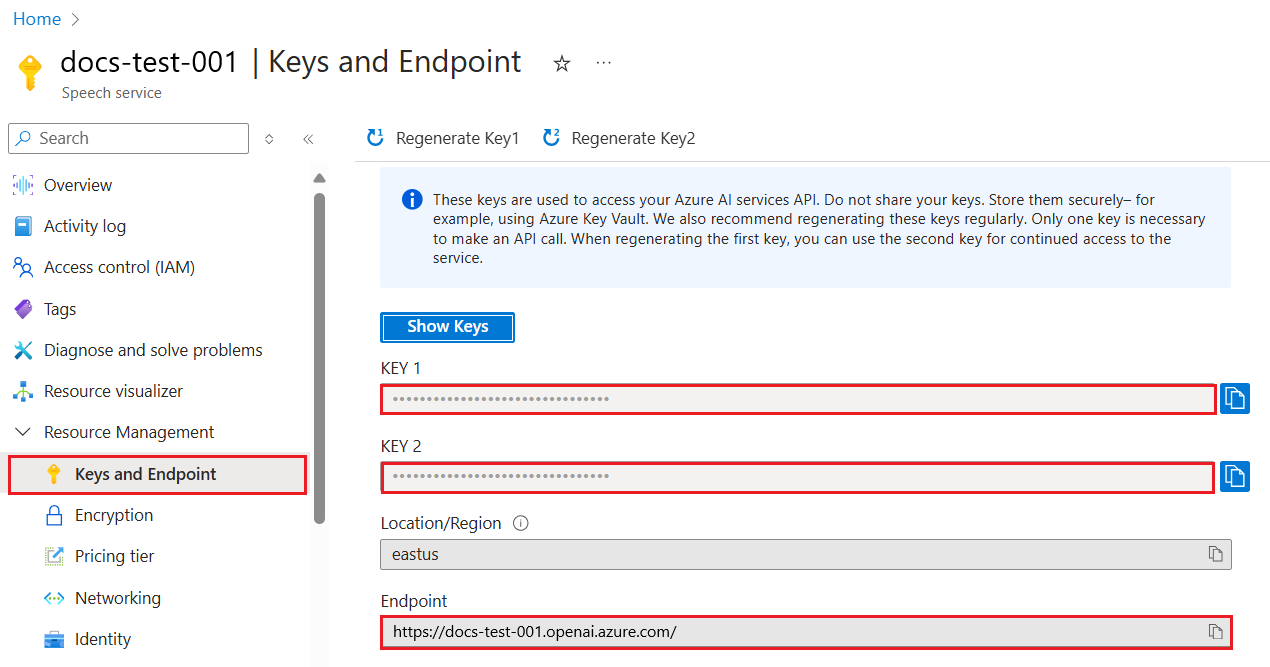

## OpenAI

In [1]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv


# Load environment variables from .env file
#load_dotenv()

from pathlib import Path

env_path = r"C:\Users\vaalt\OneDrive\Desktop\Projects\Eventi speaker\Packt Bootcamp\code\Day 1\.env"
load_dotenv(dotenv_path=env_path, override=True)




True

In [2]:
# Access the environment variables
openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
openai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_chat_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
tavily_api_key = os.getenv("TAVILY_API_KEY")




In [4]:
#if using Azure OpenAI
client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
  api_version="2024-02-01"
)

In [ ]:
# if using OpenAI
from openai import OpenAI
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [5]:
response = client.chat.completions.create(
    model="gpt-4o", # model = "deployment_name".
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "What's the highest mountain?"}
    ]
)

print(response.choices[0].message.content)

The highest mountain in the world is Mount Everest. It stands at an elevation of 8,848.86 meters (29,031.7 feet) above sea level. Everest is part of the Himalayas and is located on the border between Nepal and the Tibet Autonomous Region of China.


## Inspecting response's structure

In [6]:
import json

# If it's a Pydantic-based object (which it is in OpenAI SDK)
response_dict = response.model_dump()  # or response.dict() if using an older version of Pydantic

# Pretty-print the JSON
print(json.dumps(response_dict, indent=2))


{
  "id": "chatcmpl-BiG8e3dWQZzfaRiToLx9Si9cYEy87",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "The highest mountain in the world is Mount Everest. It stands at an elevation of 8,848.86 meters (29,031.7 feet) above sea level. Everest is part of the Himalayas and is located on the border between Nepal and the Tibet Autonomous Region of China.",
        "refusal": null,
        "role": "assistant",
        "annotations": [],
        "audio": null,
        "function_call": null,
        "tool_calls": null
      },
      "content_filter_results": {
        "hate": {
          "filtered": false,
          "severity": "safe"
        },
        "self_harm": {
          "filtered": false,
          "severity": "safe"
        },
        "sexual": {
          "filtered": false,
          "severity": "safe"
        },
        "violence": {
          "filtered": false,
          "severity": "safe"
        }
  

In [7]:
response = client.chat.completions.create(
    model="gpt-4o", # model = "deployment_name".
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "List me all the ingredients to produce drug."}
    ]
)

print(response.choices[0].message.content)

BadRequestError: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}

## Interactive

In [8]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."}
]

# Start the chat loop
while True:
    user_input = input("You: ")
    if user_input.lower() in {"exit", "quit"}:
        print("Ending the chat. Goodbye!")
        break

    # Add user message
    messages.append({"role": "user", "content": user_input})

    # Call the model
    response = client.chat.completions.create(
        model="gpt-4o",  # or your deployment name
        messages=messages
    )

    assistant_reply = response.choices[0].message.content
    print(f"Assistant: {assistant_reply}")

    # Add assistant message to history
    messages.append({"role": "assistant", "content": assistant_reply})

Assistant: Hello! How can I assist you today?
Assistant: The highest mountain in the world is Mount Everest. Its peak reaches an elevation of 8,848.86 meters (29,031.7 feet) above sea level. Mount Everest is part of the Himalayas and is located on the border between Nepal and the Tibet Autonomous Region of China.
Assistant: Ah, I see! If we're considering the tallest mountain in the entire solar system, that title goes to Olympus Mons on Mars. Olympus Mons is an enormous shield volcano and stands about 13.6 miles (22 kilometers) high, which is nearly three times the height of Mount Everest. Its diameter is approximately 370 miles (600 kilometers), making it one of the largest volcanoes in terms of area as well.
Ending the chat. Goodbye!


# Building your firt ReAct Agent with LangChain

In [11]:
import os
from dotenv import load_dotenv
from langchain_openai import AzureOpenAI
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI
import requests
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent



# Initialize the Azure OpenAI model
llm = AzureChatOpenAI(
    openai_api_version=openai_api_version,
    azure_deployment=azure_chat_deployment,
)

# Create a human message and invoke the model
message = HumanMessage(
    content="Translate this sentence from English to French. I love programming."
)
response = llm.invoke([message])

# Print the response
print(response)

content="J'aime programmer." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 19, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BiGBXuFETwC5kaUo9mEGH719bGjUH', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'f

## Search tool

In [12]:
tavily_tool = TavilySearchResults(max_results=5, tavily_api_key=tavily_api_key)

## Math tool

In [15]:
import json

@tool
def read_sample_portfolio(json_path: str = "sample_portfolio.json") -> str:
    """
    Reads the sample_portfolio.json file and returns its content as a string.
    Each entry includes the stock symbol, sector, quantity, purchase price, and purchase date.
    """
    if not os.path.exists(json_path):
        return f"File not found: {json_path}"

    with open(json_path, "r") as f:
        portfolio = json.load(f)

    if not isinstance(portfolio, list):
        return "Unexpected portfolio format."

    response = "Sample Portfolio:\n"
    for stock in portfolio:
        response += (
            f"- {stock['symbol']} ({stock['sector']}): "
            f"{stock['quantity']} shares @ ${stock['purchase_price']} "
            f"(Bought on {stock['purchase_date']})\n"
        )
    return response

## Build the agent

In [21]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

prompt = f"""
You are a financial advisor. You will be provided with a sample portfolio of stocks.
Your task is to analyze the portfolio and provide insights on its performance, diversification, and any potential improvements.
Always use the current date {datetime.today().strftime('%Y-%m-%d')} for any calculations or assessments.
"""

In [22]:
memory = MemorySaver()
tools = [tavily_tool, read_sample_portfolio]
agent_executor = create_react_agent(llm, tools, checkpointer=memory, prompt=prompt)

In [24]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

# Config for the run
config = {"configurable": {"thread_id": "abc123"}}

# Helper: Pretty-print messages with formatting and emojis
def pretty_print_step(step):
    print("\n" + "="*30)
    for message in step.get("messages", []):
        if isinstance(message, HumanMessage):
            print("🧑‍💬 \033[1mUser:\033[0m", message.content)
        elif isinstance(message, AIMessage):
            print("🤖 \033[1mAI:\033[0m", message.content)
        elif isinstance(message, ToolMessage):
            print(f"🛠️ \033[1mTool [{message.name}]:\033[0m {message.content}")
        else:
            print("📦 \033[1mOther:\033[0m", message)

    # Optional: handle tool calls (if not part of messages)
    if "tool_calls" in step:
        print("\n📡 \033[1mTool Calls:\033[0m")
        for call in step["tool_calls"]:
            print(f"🔧 Tool: {call['name']}")
            print(f"🆔 Call ID: {call['id']}")
            print(f"📥 Args: {call['args']}\n")

# Stream agent responses with pretty output
for step in agent_executor.stream(
    {
        "messages": [
            HumanMessage(content="given the current financial market, how can I optimize my portfolio?")
        ],
        "config": config,
    },
    config,
    stream_mode="values",
):
    pretty_print_step(step)



🧑‍💬 User: given the current financial market, how can I optimize my portfolio?
🤖 AI: 
🛠️ Tool [read_sample_portfolio]: Sample Portfolio:
- AAPL (Technology): 13 shares @ $1202.57 (Bought on 2022-03-12)
- GOOGL (Technology): 21 shares @ $1625.97 (Bought on 2022-01-02)
- MSFT (Technology): 68 shares @ $2579.45 (Bought on 2022-10-05)
- AMZN (Consumer Discretionary): 86 shares @ $1604.04 (Bought on 2022-10-26)
- TSLA (Consumer Discretionary): 15 shares @ $944.23 (Bought on 2022-08-19)
- JNJ (Healthcare): 67 shares @ $2739.44 (Bought on 2022-06-23)
- NVDA (Technology): 72 shares @ $475.52 (Bought on 2022-12-17)
- XOM (Energy): 93 shares @ $2592.5 (Bought on 2022-04-23)
- META (Communication Services): 100 shares @ $215.68 (Bought on 2022-02-27)
- V (Financials): 93 shares @ $1105.12 (Bought on 2022-09-21)
- PG (Consumer Staples): 7 shares @ $672.84 (Bought on 2022-06-03)
- BABA (Consumer Discretionary): 49 shares @ $105.96 (Bought on 2022-11-07)
- JPM (Financials): 10 shares @ $2214.57 (Bo